# Examining and demonstrating machine learning-powered cybersecurity risk assessment

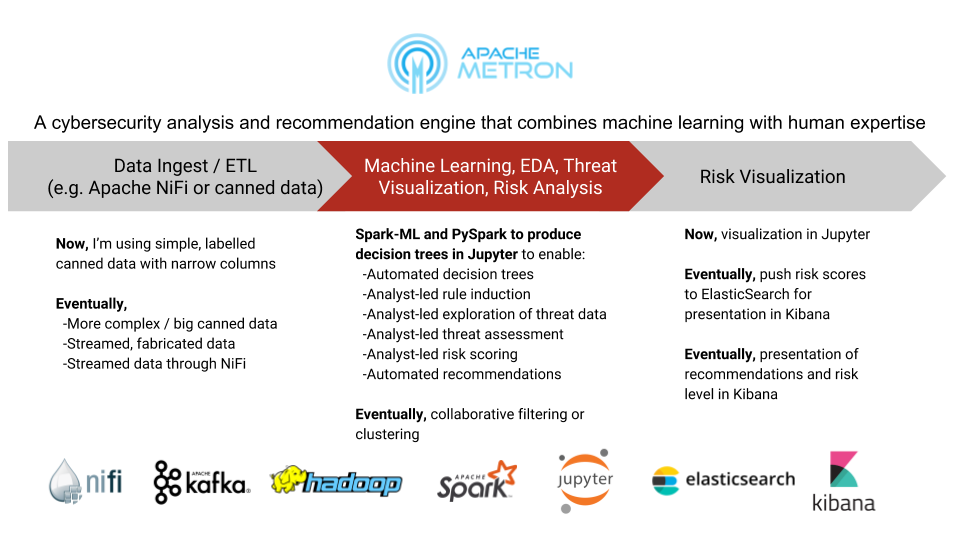

In [1]:
from IPython.display import Image
Image(filename = 'architecture.png')

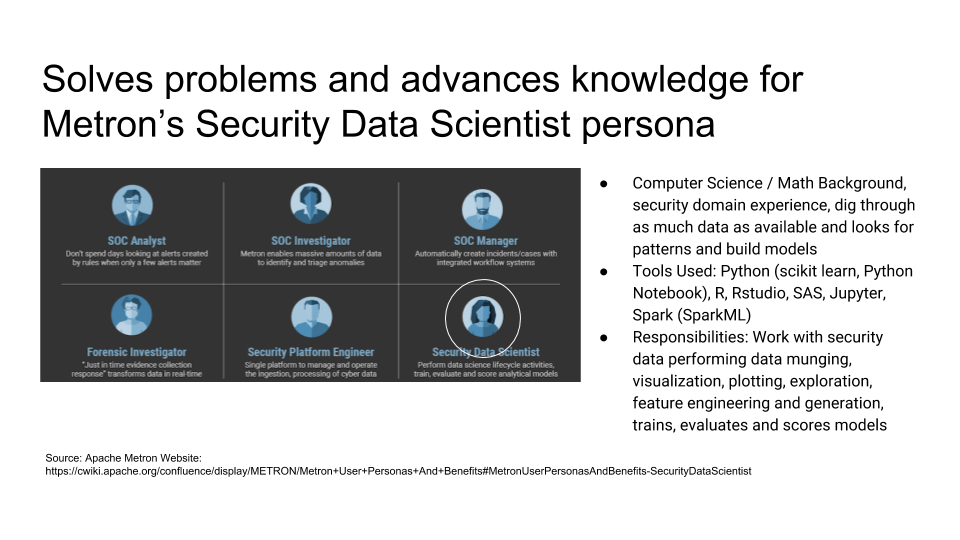

In [2]:
Image(filename = 'persona.png')

In [1]:
from pyspark.ml import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext 
import pandas as pd 

sc = SparkContext('local[1]')

In [2]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
sqlc=SQLContext(sc) 
df = pd.read_csv("connections5.csv")
sdf=sqlc.createDataFrame(df) 

def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

df2, targets = encode_target(df, "Name")

features = list(df2.columns[1:4])
y = df2["Target"]
X = df2[features]

dt = DecisionTreeClassifier(min_samples_split=20, random_state=99, max_depth=2)
dt.fit(X, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [5]:
def visualize_tree(tree, feature_names):
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
visualize_tree(dt, features)

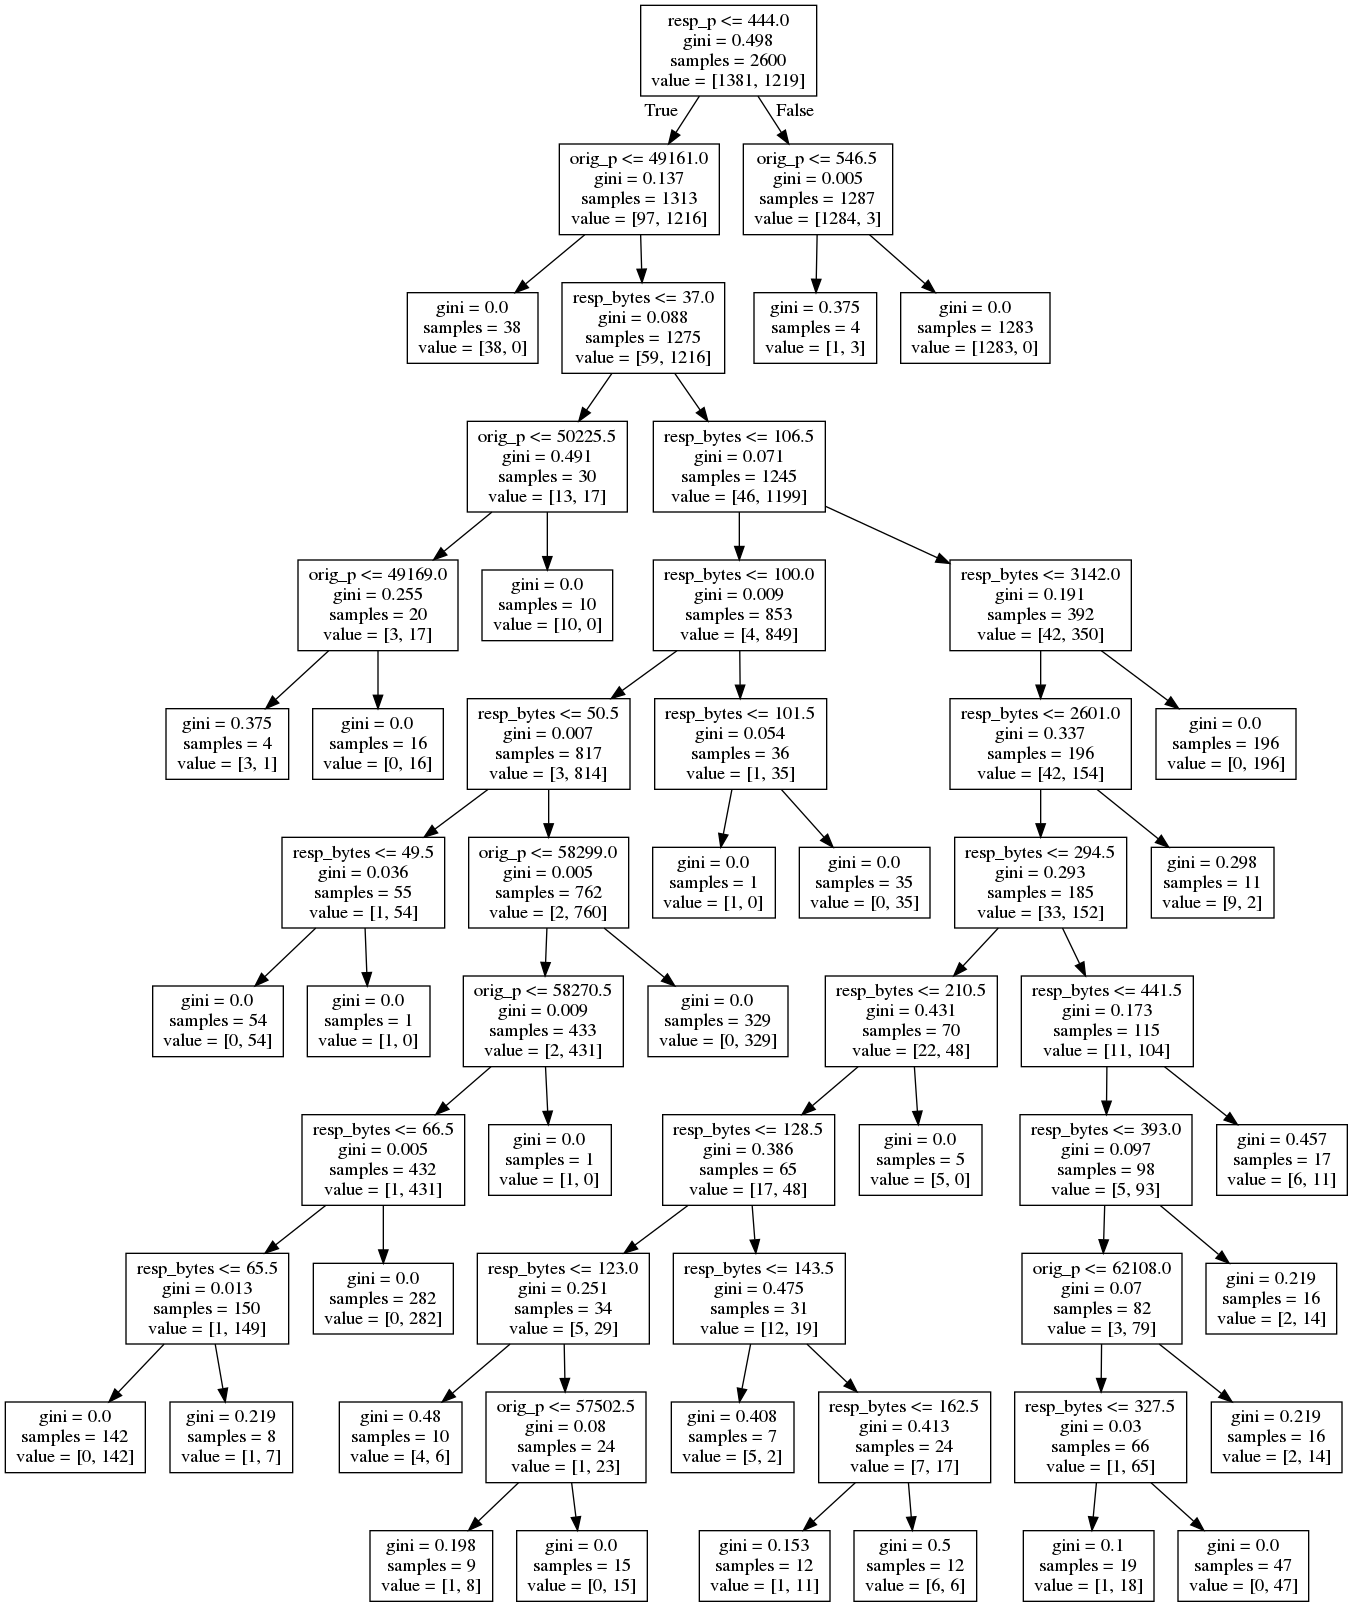

In [6]:
Image(filename = 'dt.png')

In [7]:
from pivottablejs import pivot_ui
pivot_ui(df)

In [10]:
import ipywidgets as widgets
import numpy as np
from IPython.display import display, HTML
import pandas as pd

resp_p_unique = np.unique(df2.iloc[:,2:3].values.tolist())
orig_p_unique = np.unique(df2.iloc[:,1:2].values.tolist())
resp_bytes_unique = np.unique(df2.iloc[:,3:4].values.tolist())

a = widgets.SelectMultiple(options=orig_p_unique,description='Orig_P',disabled=False)
b = widgets.SelectMultiple(options=resp_p_unique,description='Resp_P',disabled=False)
c = widgets.SelectMultiple(options=resp_bytes_unique,description='Resp_Bytes',disabled=False)
d = widgets.RadioButtons(options=[1, 2, 3],description='Threat level',disabled=False)
e = widgets.RadioButtons(options=[1, 2, 3],description='Vulnerability',disabled=False)
g = widgets.RadioButtons(options=[1, 2, 3],description='Impact',disabled=False)
h = widgets.Button(description='Score', disabled=False, button_style='info', tooltip='Do it!')

#def f(a, b, c, d, e, g):
#out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'g': g})

display(widgets.HBox([a, b, c, d, e, g]))
display(widgets.HBox([h]))


def on_button_clicked(self):
    i = d.value*e.value*g.value
    if i > 18:
        j = 'Raise an alarm'
    elif i > 9:
        j = 'Investigate further'
    else:
        j = 'Monitor further'
    df3 = pd.DataFrame({'orig_p': a.value, 'resp_p': b.value, 'resp_bytes': c.value, 'threat': d.value,
                       'vulnerability': e.value, 'impact': g.value, 'risk': i, 'Recommendation': j})
    df4 = df3[['orig_p', 'resp_p', 'resp_bytes', 'threat', 'vulnerability', 'impact','risk', 'Recommendation']]
    df4.to_csv('risktable.csv', mode='a', header=False, index = False)
    df5 = pd.read_csv('risktable.csv')
    print('\n\n Risk Table')
    display(df5.sort_values(by='risk', ascending=False))
h.on_click(on_button_clicked)



 Risk Table


,orig_p,resp_p,resp_bytes,threat,vulnerability,impact,risk,Recommendation
4,49160,80,58,3,3,3,27,Raise an alarm
6,133,67,24,3,3,3,27,Raise an alarm
11,134,443,24,3,3,3,27,Raise an alarm
12,134,443,24,3,3,3,27,Raise an alarm
13,68,67,24,2,3,3,18,Investigate further
3,49164,53,61,2,2,3,12,Investigate further
8,68,445,26,2,2,3,12,Investigate further
10,133,445,28,2,2,2,8,Monitor further
2,68,3544,26,3,1,2,6,Monitor further
5,133,53,28,3,2,1,6,Monitor further


In [9]:
df5 = pd.read_csv('risktable.csv')
pivot_ui(df5)